In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742065192.162376 2187815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742065192.179293 2187815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742065196.670761 2187815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

# Simulação

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

In [3]:
def load_file(data_dir, file_index, distribution, train_images, test_images):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            file_index = 20
            distribution = "poisson"
    '''
    index_path = "{}/indices_{}.csv".format(data_dir, file_index, distribution)
    data_path = "{}/{}/data_{}.csv".format(data_dir, distribution, file_index)
    df_index = pd.read_csv(index_path)
    df_data = pd.read_csv(data_path)

    index_train = df_index.loc[df_index.set == "train","index"].to_numpy()
    index_val = df_index.loc[df_index.set == "val","index"].to_numpy()
    index_test = df_index.loc[df_index.set == "test","index"].to_numpy()

    # Values for the thetas
    theta_train = df_data.loc[df_data.set == "train", "theta"]
    theta_val = df_data.loc[df_data.set == "val", "theta"]
    theta_test = df_data.loc[df_data.set == "test", "theta"]
    # Values for the latent variable
    m_train = df_data.loc[df_data.set == "train", "m"]
    m_val = df_data.loc[df_data.set == "val", "m"]
    m_test = df_data.loc[df_data.set == "test", "m"]
    # Values for the time variable
    t_train = df_data.loc[df_data.set == "train", "t"]
    t_val = df_data.loc[df_data.set == "val", "t"]
    t_test = df_data.loc[df_data.set == "test", "t"]
    # Values for the censorship indicators
    delta_train = df_data.loc[df_data.set == "train", "delta"]
    delta_val = df_data.loc[df_data.set == "val", "delta"]
    delta_test = df_data.loc[df_data.set == "test", "delta"]

    img_train = train_images[index_train,:,:]
    img_val = train_images[index_val,:,:]
    img_test = test_images[index_test,:,:]

    result = {
        "theta_train": theta_train, "theta_val": theta_val, "theta_test": theta_test,
        "m_train": m_train, "m_val": m_val, "m_test": m_test,
        "t_train": t_train, "t_val": t_val, "t_test": t_test,
        "delta_train": delta_train, "delta_val": delta_val, "delta_test": delta_test,
        "img_train": img_train, "img_val": img_val, "img_test": img_test,
        "index_train": index_train, "index_val": index_val, "index_test": index_test
    }
    
    return result

In [4]:
def select_model(distribution, q):
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    return log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max

def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   max_iterations = 100,
                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                   epochs = 100, batch_size = None, shuffle = True,
                   learning_rate = 0.001, run_eagerly = False,
                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                   verbose = 1, seed = 1):
    alpha0, s_t = initialize_alpha_s(t_train, delta_train, n_cuts = 5)

    # Select the MPS functions based on the chosen distribution
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)

    set_all_seeds(seed)
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    dummy_mps_model.define_structure(shape_input = img_train[0].shape, seed = seed)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      dummy_mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = max_iterations,
                      early_stopping_em = early_stopping_em, early_stopping_em_warmup = early_stopping_em_warmup, early_stopping_em_eps = early_stopping_em_eps,
                      epochs = epochs, batch_size = batch_size, shuffle = shuffle,
                      learning_rate = learning_rate, run_eagerly = run_eagerly,
                      early_stopping_nn = early_stopping_nn, early_stopping_min_delta_nn = early_stopping_min_delta_nn, early_stopping_patience_nn = early_stopping_patience_nn,
                      reduce_lr = reduce_lr, reduce_lr_steps = reduce_lr_steps, reduce_lr_factor = reduce_lr_factor,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = verbose, seed = seed, alpha_known = False)
    return results

In [25]:
file_info = load_file("SimulationDataset2/Scenario1/n1000/", 1, "logarithmic", train_images, test_images)
print( "Keys: {}".format(list(file_info.keys())) )

Keys: ['theta_train', 'theta_val', 'theta_test', 'm_train', 'm_val', 'm_test', 't_train', 't_val', 't_test', 'delta_train', 'delta_val', 'delta_test', 'img_train', 'img_val', 'img_test', 'index_train', 'index_val', 'index_test']


In [6]:
set_all_seeds(10)

sim_results = fit_cure_model("logarithmic", None,
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = None,
               seed = 1, verbose = 3)

I0000 00:00:1741326479.214027  304825 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1741326480.279925  304958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741326480.283608  304958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741326482.753925  304958 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4114 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741326482.782423  304958 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4114 MB memory:  -> devi

Iniciando passo 1


I0000 00:00:1741326484.873945  305020 cuda_dnn.cc:529] Loaded cuDNN version 90300
 18%|█▊        | 18/100 [00:03<00:16,  4.87epoch/s, loss=0.649, loss_val=0.644]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.3321155115694157e-05
Distância Parâmetros Alpha: 20.972088561091038
Média das distâncias: 10.486055941123077
Iniciando passo 2


  7%|▋         | 7/100 [00:01<00:16,  5.75epoch/s, loss=0.809, loss_val=0.799]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.465978441092563e-06
Distância Parâmetros Alpha: 1.7378939867596237
Média das distâncias: 0.8689482263690324
Iniciando passo 3


 16%|█▌        | 16/100 [00:01<00:10,  8.37epoch/s, loss=0.892, loss_val=0.88] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.4191273104579657e-06
Distância Parâmetros Alpha: 0.39423240966467943
Média das distâncias: 0.19711741439599495
Iniciando passo 4


 71%|███████   | 71/100 [00:05<00:02, 13.02epoch/s, loss=0.842, loss_val=0.854]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 0.00021043098585607004
Distância Parâmetros Alpha: 0.05395922174662659
Média das distâncias: 0.02708482636624133
Iniciando passo 5


  6%|▌         | 6/100 [00:01<00:18,  5.14epoch/s, loss=0.937, loss_val=0.933]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 9.655124520500806e-07
Distância Parâmetros Alpha: 0.07471682253293166
Média das distâncias: 0.03735889402269185
Iniciando passo 6


  8%|▊         | 8/100 [00:01<00:15,  6.09epoch/s, loss=1.9, loss_val=1.93] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.8653509562790263e-07
Distância Parâmetros Alpha: 0.8902352114268229
Média das distâncias: 0.4451177489809593
Iniciando passo 7


  8%|▊         | 8/100 [00:01<00:16,  5.49epoch/s, loss=2.11, loss_val=2.14]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.410838946593667e-07
Distância Parâmetros Alpha: 0.24390547389098305
Média das distâncias: 0.12195290748743885
Iniciando passo 8


  8%|▊         | 8/100 [00:01<00:14,  6.21epoch/s, loss=2.08, loss_val=2.11]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.252930020551818e-07
Distância Parâmetros Alpha: 0.10545571138975812
Média das distâncias: 0.052728018341380085
Iniciando passo 9


  8%|▊         | 8/100 [00:01<00:14,  6.20epoch/s, loss=1.99, loss_val=2.03]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.8372881587559056e-07
Distância Parâmetros Alpha: 0.08576265711209134
Média das distâncias: 0.04288147042045361
Iniciando passo 10


  8%|▊         | 8/100 [00:01<00:14,  6.33epoch/s, loss=1.83, loss_val=1.86]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.3641742670604344e-07
Distância Parâmetros Alpha: 0.1419719970651792
Média das distâncias: 0.07098611674130297
Learning rate reduzida para 0.0001
Iniciando passo 11


 10%|█         | 10/100 [00:01<00:12,  7.01epoch/s, loss=1.69, loss_val=1.79]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.1712611496629148e-07
Distância Parâmetros Alpha: 0.2172819002121212
Média das distâncias: 0.10864105866911809
Iniciando passo 12


 17%|█▋        | 17/100 [00:01<00:09,  8.90epoch/s, loss=1.51, loss_val=1.57]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.9811689676573824e-07
Distância Parâmetros Alpha: 0.1035837864498061
Média das distâncias: 0.051791992283351435
Iniciando passo 13


 20%|██        | 20/100 [00:02<00:08,  9.60epoch/s, loss=1.46, loss_val=1.49]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.5906939465653394e-07
Distância Parâmetros Alpha: 0.009492749061429205
Média das distâncias: 0.0047465040654119306
Iniciando passo 14


100%|██████████| 100/100 [00:07<00:00, 12.82epoch/s, loss=1.41, loss_val=1.45]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 6.3274522361902105e-06
Distância Parâmetros Alpha: 0.00112558324098802
Média das distâncias: 0.0005659553466121052
Iniciando passo 15


  8%|▊         | 8/100 [00:01<00:18,  5.02epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 5.479537759890125e-09
Distância Parâmetros Alpha: 0.00026875151222758106
Média das distâncias: 0.00013437849588267048
Iniciando passo 16


 17%|█▋        | 17/100 [00:02<00:10,  7.95epoch/s, loss=1.41, loss_val=1.44]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 5.508867620144344e-08
Distância Parâmetros Alpha: 0.00015383710641424676
Média das distâncias: 7.69460975452241e-05
Iniciando passo 17


  8%|▊         | 8/100 [00:01<00:15,  6.04epoch/s, loss=1.4, loss_val=1.43] 


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.601664539289963e-09
Distância Parâmetros Alpha: 2.5605273516240703e-05
Média das distâncias: 1.2804437590389996e-05
Iniciando passo 18


 17%|█▋        | 17/100 [00:02<00:10,  8.20epoch/s, loss=1.42, loss_val=1.45]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 4.311039714077919e-08
Distância Parâmetros Alpha: 0.00015520689368862055
Média das distâncias: 7.762500204288067e-05
Iniciando passo 19


  8%|▊         | 8/100 [00:01<00:15,  5.97epoch/s, loss=1.41, loss_val=1.44]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.64525249206666e-09
Distância Parâmetros Alpha: 1.0819644342300611e-05
Média das distâncias: 5.411644797396339e-06
Iniciando passo 20


 17%|█▋        | 17/100 [00:01<00:09,  9.02epoch/s, loss=1.42, loss_val=1.46]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.853079260202023e-08
Distância Parâmetros Alpha: 0.00013848085611654977
Média das distâncias: 6.925969345457589e-05
Learning rate reduzida para 1e-05
Iniciando passo 21


 11%|█         | 11/100 [00:01<00:12,  6.86epoch/s, loss=1.42, loss_val=1.45]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 7.44474505156486e-10
Distância Parâmetros Alpha: 5.937486047108306e-06
Média das distâncias: 2.969115260806731e-06
Iniciando passo 22


  8%|▊         | 8/100 [00:01<00:15,  5.82epoch/s, loss=1.41, loss_val=1.44]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 2.6435572784335884e-10
Distância Parâmetros Alpha: 2.0458216578480874e-05
Média das distâncias: 1.0229240467104358e-05
Iniciando passo 23


  7%|▋         | 7/100 [00:01<00:17,  5.20epoch/s, loss=1.41, loss_val=1.44]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.3700651445159015e-10
Distância Parâmetros Alpha: 3.108715855684077e-05
Média das distâncias: 1.554364778167761e-05
Iniciando passo 24


  7%|▋         | 7/100 [00:01<00:17,  5.39epoch/s, loss=1.4, loss_val=1.43]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.4092950519835273e-10
Distância Parâmetros Alpha: 2.694980351424417e-05
Média das distâncias: 1.3474972221874684e-05
Iniciando passo 25


  7%|▋         | 7/100 [00:01<00:16,  5.68epoch/s, loss=1.4, loss_val=1.43]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.4137764505311555e-10
Distância Parâmetros Alpha: 1.773385222527908e-05
Média das distâncias: 8.866996801462067e-06
Iniciando passo 26


  7%|▋         | 7/100 [00:01<00:16,  5.66epoch/s, loss=1.4, loss_val=1.43]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.4166030346602956e-10
Distância Parâmetros Alpha: 1.2310995234961096e-05
Média das distâncias: 6.155568447632281e-06
Iniciando passo 27


  7%|▋         | 7/100 [00:01<00:16,  5.81epoch/s, loss=1.4, loss_val=1.43]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.4770779481678366e-10
Distância Parâmetros Alpha: 9.43956717438047e-06
Média das distâncias: 4.719857441087644e-06
Iniciando passo 28


  7%|▋         | 7/100 [00:01<00:18,  5.13epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.4643862515089112e-10
Distância Parâmetros Alpha: 7.266255122125708e-06
Média das distâncias: 3.6332007803754296e-06
Iniciando passo 29


  7%|▋         | 7/100 [00:01<00:16,  5.78epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.5175609544409024e-10
Distância Parâmetros Alpha: 6.1443098534916466e-06
Média das distâncias: 3.0722308047935453e-06
Iniciando passo 30


  7%|▋         | 7/100 [00:01<00:15,  5.85epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 1.490440917282392e-10
Distância Parâmetros Alpha: 4.930969303752858e-06
Média das distâncias: 2.4655591739222933e-06
Learning rate reduzida para 1.0000000000000002e-06
Iniciando passo 31


 13%|█▎        | 13/100 [00:01<00:11,  7.42epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 4.231961841391172e-11
Distância Parâmetros Alpha: 3.9120560457187954e-06
Média das distâncias: 1.9560491826686045e-06
Iniciando passo 32


 12%|█▏        | 12/100 [00:01<00:11,  7.69epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.497406158845114e-11
Distância Parâmetros Alpha: 4.264308280884283e-06
Média das distâncias: 2.132171627472936e-06
Iniciando passo 33


 16%|█▌        | 16/100 [00:01<00:09,  8.56epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 8.768627121732741e-11
Distância Parâmetros Alpha: 3.948251910346473e-06
Média das distâncias: 1.974169798308845e-06
Iniciando passo 34


 12%|█▏        | 12/100 [00:01<00:11,  7.81epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 3.564829539737556e-11
Distância Parâmetros Alpha: 3.132366391293159e-06
Média das distâncias: 1.5662010197942782e-06
Iniciando passo 35


 14%|█▍        | 14/100 [00:01<00:10,  7.92epoch/s, loss=1.39, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 5.941970140081355e-11
Distância Parâmetros Alpha: 2.763735535533148e-06
Média das distâncias: 1.3818974776172745e-06
Iniciando passo 36


 13%|█▎        | 13/100 [00:01<00:11,  7.56epoch/s, loss=1.38, loss_val=1.42]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 4.773811011924774e-11
Distância Parâmetros Alpha: 2.343743757726761e-06
Média das distâncias: 1.17189574791844e-06
Iniciando passo 37


 13%|█▎        | 13/100 [00:01<00:11,  7.52epoch/s, loss=1.38, loss_val=1.41]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 4.8793333356829184e-11
Distância Parâmetros Alpha: 2.0709417294709067e-06
Média das distâncias: 1.0354952614021318e-06
Iniciando passo 38


 14%|█▍        | 14/100 [00:01<00:10,  7.93epoch/s, loss=1.38, loss_val=1.41]


Iniciando treinamento:
Tamanho da amostra de treino: 1000
Tamanho da amostra de validação: 214
Distância Parâmetros Rede Neural: 6.151634566914264e-11
Distância Parâmetros Alpha: 1.8106544608379645e-06
Média das distâncias: 9.053579885918168e-07
Algoritmo convergiu após 38 iterações. Retornando.
Número de arquivos no diretório: 38


In [7]:
alpha0, s_t = initialize_alpha_s(file_info["t_train"], file_info["delta_train"], n_cuts = 5)

alpha estimado: [0.82686866 0.41102061 0.21940883 0.05134796 0.02443048 1.        ]
alpha xie: [1 1 1 1 1 1]


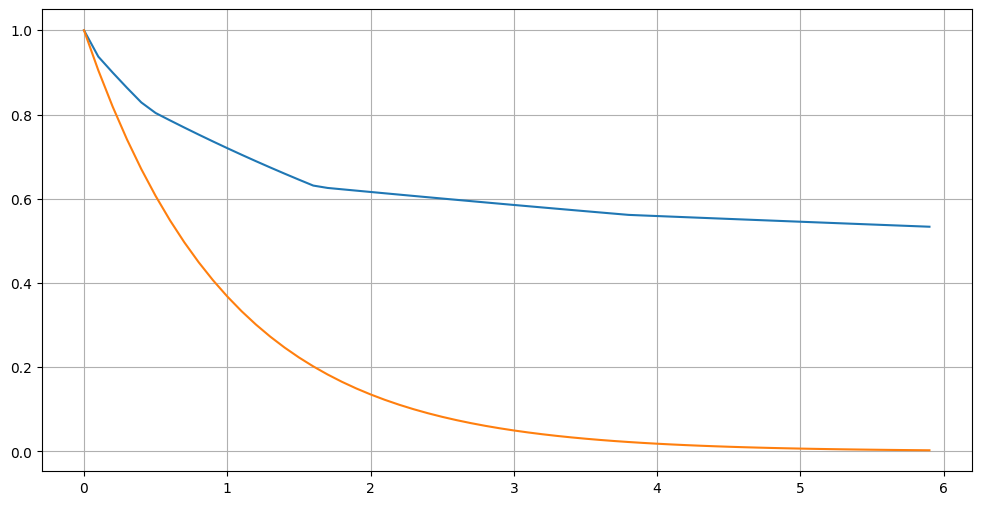

In [8]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.grid()
plt.show()

alpha estimado: [1.6744241  1.06043366 0.9532889  0.67662189 3.48376504 1.        ]
alpha xie: [1 1 1 1 1 1]


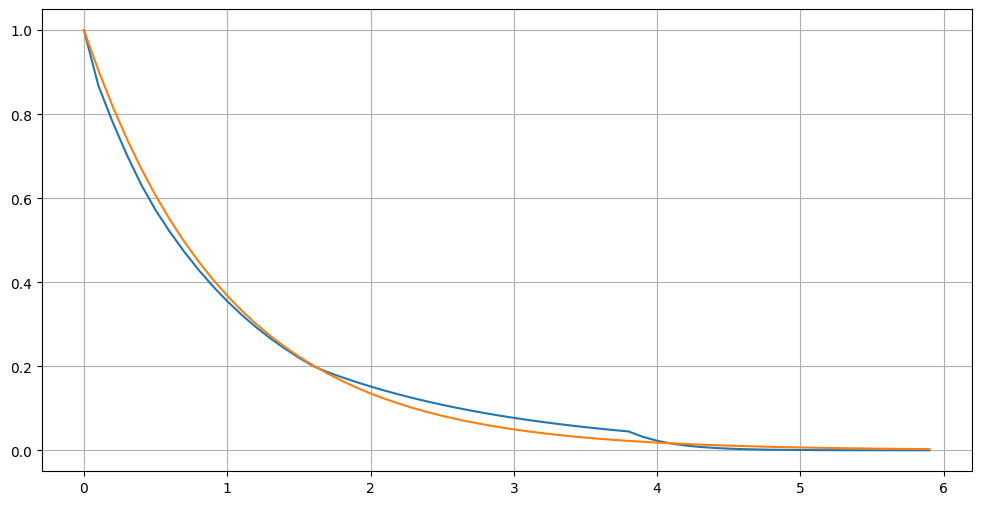

In [8]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.grid()
plt.show()

In [38]:
theta = pd.read_csv("SimulationDataset2/Scenario2/n500/rgp32/data_1.csv").theta

p = 1.0/C_rgp(3/2)(theta)
np.unique(p)

array([0.6 , 0.7 , 0.8 , 0.9 , 0.95])

In [9]:
eta_pred_train = sim_results["new_model"].predict(file_info["img_train"])
eta_pred_test = sim_results["new_model"].predict(file_info["img_test"])

I0000 00:00:1741326283.858422  261575 cuda_dnn.cc:529] Loaded cuDNN version 90300


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [10]:
print("MAE M - train: {}".format( np.mean( np.abs(file_info["m_train"].to_numpy() - sim_results["m_history"][-1])) ))
print("MAE M - test: {}".format( np.mean( np.abs(file_info["m_test"].to_numpy() - sim_results["m_val_history"][-1])) ))

MAE M - train: 160.52308015658392
MAE M - test: 202.7824023573295


# Proper simulations

In [1]:
###### import os, shutil
from pathlib import Path

print("Creating directories structure")
dists_scenario1 = ["poisson", "logarithmic", "geometric", "mvnb2", "bernoulli", "bin5", "rgp10"]
dists_scenario2 = ["borel", "rgp2", "haight", "geeta3"]
for dist in dists_scenario1:
    for j in range(1,101):
        Path("SimulationResults/Scenario1/n500/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario1/n1000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario1/n3000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
for dist in dists_scenario2:
    for j in range(1,101):
        Path("SimulationResults/Scenario2/n500/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario2/n1000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)
        Path("SimulationResults/Scenario2/n3000/{}/{}".format(dist,j)).mkdir(parents=True, exist_ok=True)

Creating directories structure


Below, there is a list of everything that will be saved in each simulation. We must consider the disk space this process might cost us.

For each simulation, we will save:
* Last estimated weights of the fitted model neural network
* For all individuals from the dataset (train, val and test), saves a table with
    * Estimated cure probability $\widehat{p}$
    * Estimated $\widehat{\theta}$
    * Estimated $\widehat{m}$ value
    * Estimated $\widehat{\alpha}$
    * Estimated $s_t$ from the knots of the piecewise exponential (depends on the quantiles of the lifetime observations)
    * Set of the individual (train, val or test)

Note that the real values for each individual is already accounted for in the original simulated dataset. After all simulations, we will compare the real values from the simulated datasets with the estimations saved from these simulations. With this set of informations, we can compute every prediction of interest for each individual, including the estimated AUC metric for the cured ones.

In order to get some more information on the general scenario, we will also save the execution times for each dataset, the final loss function value after training, if the algorithm converged or not and the number of steps the EM needed.

In [6]:
def run_scenario(data_dir, distribution, q, train_images, test_images, start_index = 1, seed = 1):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            distribution = "poisson"
    '''

    # The name of the distribution does not have any numbers. Simulations like the RPG which are considered for two different values of q have different numbers associated to their directory, which must be conserved for the function to know where to save the files. But for selection of the model in select_model, we must use only "rgp"
    distribution_name = ''.join([i for i in distribution if not i.isdigit()])
    
    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution_name, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)
    
    execution_times = []
    loss_values = []
    loss_val_values = []
    converged = []
    steps = []
    for i in tqdm(range(start_index, 2)):
        # Load the simulated dataset
        sim_dataset = load_file(data_dir, i, distribution, train_images, test_images)
        
        _, s_t = initialize_alpha_s(sim_dataset["t_train"], file_info["delta_train"], n_cuts = 5)
        start_time = time()
        result = fit_cure_model(distribution_name, q,
                                sim_dataset["t_train"], sim_dataset["t_val"],
                                sim_dataset["delta_train"], sim_dataset["delta_val"],
                                sim_dataset["img_train"], sim_dataset["img_val"],
                                batch_size = None, max_iterations = 100,
                                seed = seed, verbose = 0)
        elapsed_time = time() - start_time
        execution_times.append(elapsed_time)
        
        # Recover information on the inference of parameters
        eta_train_pred = result["new_model"].predict(sim_dataset["img_train"], verbose = 0)
        eta_val_pred = result["new_model"].predict(sim_dataset["img_val"], verbose = 0)
        eta_test_pred = result["new_model"].predict(sim_dataset["img_test"], verbose = 0)
        
        p_train_pred = result["new_model"].link_func(eta_train_pred).numpy().flatten()
        p_val_pred = result["new_model"].link_func(eta_val_pred).numpy().flatten()
        p_test_pred = result["new_model"].link_func(eta_test_pred).numpy().flatten()
        p_pred = np.concatenate([p_train_pred, p_val_pred, p_test_pred])
        
        log_p_train_pred = np.log(p_train_pred)
        log_p_val_pred = np.log(p_val_pred)
        log_p_test_pred = np.log(p_test_pred)
        
        log_a0 = log_a_tf( tf.constant(0.0, dtype = tf.float64) )
        
        theta_train_pred = C_inv_tf( np.exp(log_a0 - log_p_train_pred) ).numpy()
        theta_val_pred = C_inv_tf( np.exp(log_a0 - log_p_val_pred) ).numpy()
        theta_test_pred = C_inv_tf( np.exp(log_a0 - log_p_test_pred) ).numpy()
        theta_pred = np.concatenate([theta_train_pred, theta_val_pred, theta_test_pred])
        
        m_train_pred = result["m_history"][-1]
        m_val_pred = result["m_val_history"][-1]
        m_test_pred = update_m_mps(result["new_model"], result["new_alpha"], s_t, sim_dataset["img_test"], sim_dataset["t_test"], sim_dataset["delta_test"])
        m_pred = np.concatenate([m_train_pred, m_val_pred, m_test_pred])

        sets = np.concatenate([np.repeat("train", len(theta_train_pred)), np.repeat("val", len(theta_val_pred)), np.repeat("test", len(theta_test_pred))])

        results_dir = data_dir.split("/")
        results_dir = "{}/{}".format("SimulationResults", "/".join(results_dir[1:]))
        # pd.DataFrame({"p_pred": p_pred, "theta_pred": theta_pred, "m_pred": m_pred, "set": sets}).to_csv(
        #     "{}/{}/{}/data_pred.csv".format(results_dir, distribution, i), index = False
        # )
        
        # Save the model weights
        # result["new_model"].save_model("{}/{}/{}/model.weights.h5".format(results_dir, distribution, i))

        # Save the piecewise exponential estimated parameters
        # save_alpha_s(result["new_alpha"], s_t, filename = "{}/{}/{}/alpha_s.csv".format(results_dir, distribution, i))

        loss_values.append( result["loss_history"][-1] )
        loss_val_values.append( result["loss_val_history"][-1] )
        converged.append( result["converged"] )
        steps.append( result["steps"] )

    # pd.DataFrame({"execution_times": execution_times, "loss_values": loss_values, "loss_val_values": loss_val_values, "converged": converged, "steps": steps}).to_csv(
    #     "{}/{}/sim_metadata.csv".format(results_dir, distribution, i), index = False
    # )

Now that everything is working, we just need to pass all this code to a .py file so we can execute multiple simulations at once. We note that the GPU memory is used only partially with each simulation scenario. We would like to verify if an entire distribution scenario (for example, poisson for n500, n1000 and n3000) may be executed all at once.

In [5]:
def plot_S1(results, n, scenario, distribution, end_index = 101, ci = True, ax = None, title = "", outliers = 5):
    if(ax is None):
        fig, ax = plt.subplots(figsize = (12, 6))

    interest_indices = []
    for i in range(1, end_index):
        data = pd.read_csv("SimulationResults{}/Scenario{}/n{}/{}/{}/alpha_s.csv".format(results, scenario, n, distribution, i))
        s_t = data.s.to_numpy()
        alpha = data.alpha.to_numpy()
        if(i == 1):
            tv = np.arange(0, 5, 0.01)
            S1i = S1(tv, alpha, s_t)
    
            # Initialize the table with all estimated survival curves
            S1i_table = np.zeros((end_index-1, len(S1i)))
            S1i_table[0,:] = S1i
            
            alpha_xie = np.array([1, 1, 1, 1, 1, 1])
            S1v_xie = S1(tv, alpha_xie, s_t)
        else:
            S1i = S1(tv, alpha, s_t)
            S1i_table[i-1,:] = S1i

        ax.plot(tv, S1i, color = "black", alpha = 0.1)

            
    # Get the indices for which the simulation did not converge
    nan_indices = np.unique( np.where( np.isnan(S1i_table) )[0] )
    if(len(nan_indices) > 0):
        print("n = {} - {}: Simulações {} não obtiveram convergência!".format(n, distribution, nan_indices))
    # Remove the nan observations from the table
    S1i_table = np.delete(S1i_table, nan_indices, axis = 0)

    # Obtain the median survival curve
    S1_median = np.quantile(S1i_table, 0.50, axis = 0)
    
    # Takes the mean squared distances of all curves to the median
    median_distances = np.mean( (S1i_table - S1_median)**2, axis = 1 )
    # print(median_distances)
    
    # Sorts the distances vector to get the ranks of each curve (i.e. sorts the curves by distance from the median curve)
    index_sort_distances = np.argsort(np.argsort( median_distances ))
    
    # Remove from the table of curves the prespecified number of outlier curves (which are discarded for the predictions)
    S1i_table = S1i_table[ index_sort_distances < (end_index - 1 - outliers) , :]    
    
    S1q95 = np.quantile(S1i_table, 0.95, axis = 0)
    S1q05 = np.quantile(S1i_table, 0.05, axis = 0)
    S1_median = np.quantile(S1i_table, 0.50, axis = 0)
    
    ax.plot(tv, S1v_xie, color = "blue", linewidth = 2)
    # ax.plot(tv, np.exp(-tv), color = "black", linewidth = 2)
    
    if(ci):
        ax.plot(tv, S1q95, color = "red", linestyle = "dashed")
        ax.plot(tv, S1q05, color = "red", linestyle = "dashed")
        ax.plot(tv, S1_median, color = "red", linewidth = 2)

    ax.set_title(title)

In [39]:
tv = np.arange(0, 5, 0.01)
S1i_table = np.random.normal(loc = 0, scale = 1.0, size = (101-1, 5))
median = np.array([1,2,3,4,5])
distances = np.mean( (S1i_table - median)**2, axis = 1 )
np.argsort(distances) < 95

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

[5.80151868 1.7502868  1.33843898 1.3537772  2.1899318  1.        ]
[6.25070406 2.03763145 1.3626021  1.18873479 3.09659481 1.        ]
[6.49454772 1.85408704 1.50652785 1.09422724 1.46360451 1.        ]
[5.77788612 1.65293283 1.34851666 1.30072541 2.91808953 1.        ]
[6.06814253 1.69616505 1.41990314 1.2509304  1.3723555  1.        ]
[5.54108885 1.8302843  1.30574923 1.43540941 0.         1.        ]
[5.91393574 1.81184392 1.35927518 1.23875015 2.54941611 1.        ]
[6.17638347 1.98241312 1.37959172 1.17200967 6.30086163 1.        ]
[4.76666451 1.61539039 1.43012998 1.11914305 3.43988376 1.        ]
[5.95386034 2.02392254 1.3738543  1.46644809 8.9174911  1.        ]
[6.35031046 1.71096395 1.32771864 1.64673462 6.75943788 1.        ]
[5.82373555 1.70546115 1.25929178 1.4458056  2.1089188  1.        ]
[5.14074897 1.62419307 1.44813907 1.32459624 4.83006751 1.        ]
[6.19184352 1.84453174 1.4995658  1.21009789 3.23534211 1.        ]
[6.13906476 1.98064239 1.32684916 1.34097425 2.3

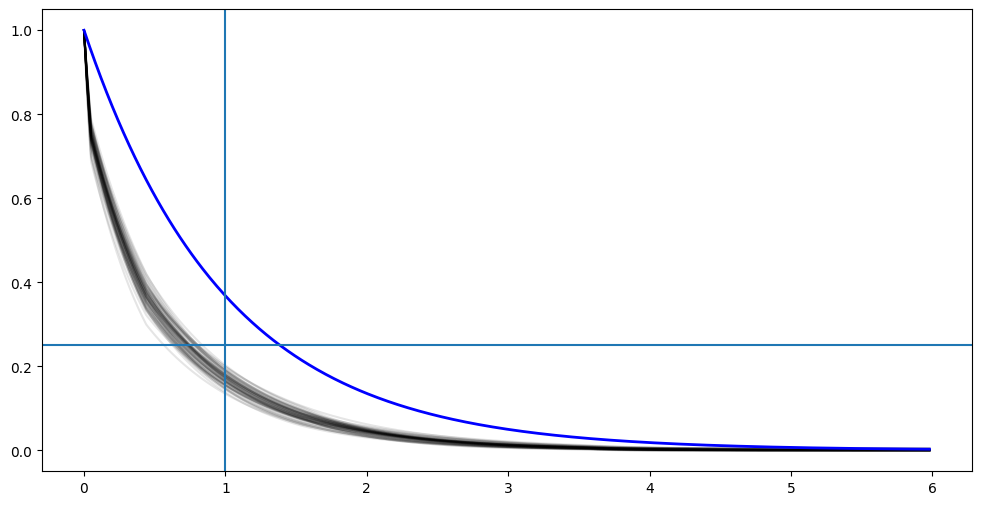

In [8]:
interest_indices = plot_S1("2", 3000, 1, "logarithmic", 101, ci = False)
plt.axhline(0.25)
plt.axvline(1)

In [9]:
np.array(interest_indices)

array([ 2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 24, 26,
       29, 35, 36, 37, 38, 40, 43, 44, 45, 46, 47, 50, 51, 52, 53, 56, 57,
       60, 62, 63, 64, 69, 70, 71, 72, 78, 79, 80, 83, 85, 86, 87, 92, 93,
       94, 95, 96, 98, 99])

In [12]:
file_info = load_file("SimulationDataset{}/Scenario{}/n{}/".format(2, 1, 3000), 2, "logarithmic", train_images, test_images)

In [13]:
set_all_seeds(10)

sim_results = fit_cure_model("logarithmic", None,
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = None,
               seed = 1, verbose = 3)

I0000 00:00:1741408450.329985  146140 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1741408451.683592  146418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741408451.687158  146418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741408454.860967  146418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741408454.914867  146418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4102 MB memory:  -> devi

Iniciando passo 1


I0000 00:00:1741408456.871795  146491 cuda_dnn.cc:529] Loaded cuDNN version 90300
  9%|▉         | 9/100 [00:04<00:48,  1.86epoch/s, loss=0.813, loss_val=0.808]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.3534433421566543e-06
Distância Parâmetros Alpha: 285.475452680208
Média das distâncias: 142.73772801682566
Iniciando passo 2


100%|██████████| 100/100 [00:19<00:00,  5.12epoch/s, loss=0.901, loss_val=0.902]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.3401926362719056e-05
Distância Parâmetros Alpha: 97.5220679265219
Média das distâncias: 48.76104566422413
Iniciando passo 3


  9%|▉         | 9/100 [00:02<00:28,  3.21epoch/s, loss=0.974, loss_val=0.948]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 9.847805256600003e-08
Distância Parâmetros Alpha: 3.1159895169003655
Média das distâncias: 1.557994807689209
Iniciando passo 4


  6%|▌         | 6/100 [00:01<00:28,  3.26epoch/s, loss=1.6, loss_val=1.59] 


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.898888722699756e-08
Distância Parâmetros Alpha: 4.766135370309668
Média das distâncias: 2.3830677096492776
Iniciando passo 5


 31%|███       | 31/100 [00:08<00:18,  3.70epoch/s, loss=0.822, loss_val=0.813]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.856286797034085e-07
Distância Parâmetros Alpha: 14.876203139475122
Média das distâncias: 7.438101812551901
Iniciando passo 6


  6%|▌         | 6/100 [00:01<00:28,  3.25epoch/s, loss=0.924, loss_val=0.908]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.842344334467022e-08
Distância Parâmetros Alpha: 1.658833837597254
Média das distâncias: 0.8294169430103486
Iniciando passo 7


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.7436914947884537e-08
Distância Parâmetros Alpha: 9.493883721719936
Média das distâncias: 4.746941874578425
Iniciando passo 8


  8%|▊         | 8/100 [00:02<00:24,  3.68epoch/s, loss=1.69, loss_val=1.67]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.4514764624722717e-08
Distância Parâmetros Alpha: 1.4725969995964618
Média das distâncias: 0.7362985120556133
Iniciando passo 9


  8%|▊         | 8/100 [00:02<00:25,  3.68epoch/s, loss=1.64, loss_val=1.62]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.214144060541989e-08
Distância Parâmetros Alpha: 0.3772276608881094
Média das distâncias: 0.188613841514775
Iniciando passo 10


  8%|▊         | 8/100 [00:02<00:23,  3.99epoch/s, loss=1.56, loss_val=1.54]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.365447563533146e-08
Distância Parâmetros Alpha: 0.12198607704538117
Média das distâncias: 0.060993050349928406
Learning rate reduzida para 0.0001
Iniciando passo 11


 11%|█         | 11/100 [00:02<00:20,  4.26epoch/s, loss=1.41, loss_val=1.43]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.5757463735230063e-08
Distância Parâmetros Alpha: 0.04539302296879632
Média das distâncias: 0.022696519363130028
Iniciando passo 12


100%|██████████| 100/100 [00:19<00:00,  5.02epoch/s, loss=1.27, loss_val=1.27]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.917338952587459e-07
Distância Parâmetros Alpha: 0.002002603282949674
Média das distâncias: 0.0010016475084224665
Iniciando passo 13


 16%|█▌        | 16/100 [00:04<00:22,  3.71epoch/s, loss=1.25, loss_val=1.25]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.0392285023530593e-08
Distância Parâmetros Alpha: 0.00195851997240888
Média das distâncias: 0.0009792651823469518
Iniciando passo 14


 17%|█▋        | 17/100 [00:04<00:20,  4.09epoch/s, loss=1.24, loss_val=1.24]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 8.3725931691517e-09
Distância Parâmetros Alpha: 0.0013778334524489576
Média das distâncias: 0.0006889209125210634
Iniciando passo 15


  8%|▊         | 8/100 [00:02<00:26,  3.46epoch/s, loss=1.23, loss_val=1.23]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.481501173382636e-10
Distância Parâmetros Alpha: 0.0012446904880334775
Média das distâncias: 0.0006223455680917974
Iniciando passo 16


 36%|███▌      | 36/100 [00:08<00:15,  4.22epoch/s, loss=1.23, loss_val=1.24]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.7240500231923625e-08
Distância Parâmetros Alpha: 5.7959809917816826e-05
Média das distâncias: 2.9008525209024374e-05
Iniciando passo 17


  8%|▊         | 8/100 [00:02<00:26,  3.48epoch/s, loss=1.22, loss_val=1.22]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.848586705061894e-10
Distância Parâmetros Alpha: 0.0006210370702902656
Média das distâncias: 0.00031051882757446807
Iniciando passo 18


 17%|█▋        | 17/100 [00:04<00:20,  4.05epoch/s, loss=1.23, loss_val=1.23]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.470827699038186e-09
Distância Parâmetros Alpha: 0.00016696150767000996
Média das distâncias: 8.348398924885449e-05
Iniciando passo 19


  8%|▊         | 8/100 [00:02<00:27,  3.37epoch/s, loss=1.22, loss_val=1.22]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.7534538534049687e-10
Distância Parâmetros Alpha: 0.00013119659240034374
Média das distâncias: 6.559848387286454e-05
Iniciando passo 20


 17%|█▋        | 17/100 [00:04<00:21,  3.88epoch/s, loss=1.23, loss_val=1.23]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.244089919807702e-09
Distância Parâmetros Alpha: 0.00012242740386513747
Média das distâncias: 6.121682397752864e-05
Learning rate reduzida para 1e-05
Iniciando passo 21


 12%|█▏        | 12/100 [00:03<00:24,  3.61epoch/s, loss=1.22, loss_val=1.22]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 8.892420915464942e-11
Distância Parâmetros Alpha: 0.00011288532436673443
Média das distâncias: 5.644270664547179e-05
Iniciando passo 22


  9%|▉         | 9/100 [00:02<00:29,  3.09epoch/s, loss=1.21, loss_val=1.21]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.156737566472393e-11
Distância Parâmetros Alpha: 0.0010770381768168249
Média das distâncias: 0.0005385191041921003
Iniciando passo 23


  8%|▊         | 8/100 [00:02<00:31,  2.95epoch/s, loss=1.2, loss_val=1.21] 


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.975409418243002e-11
Distância Parâmetros Alpha: 0.0010230740336771677
Média das distâncias: 0.000511537026715631
Iniciando passo 24


  8%|▊         | 8/100 [00:02<00:28,  3.23epoch/s, loss=1.2, loss_val=1.2]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.9469707498541998e-11
Distância Parâmetros Alpha: 0.0009221617793346523
Média das distâncias: 0.0004610808994021799
Iniciando passo 25


  7%|▋         | 7/100 [00:02<00:28,  3.32epoch/s, loss=1.2, loss_val=1.2]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.0390519224022488e-11
Distância Parâmetros Alpha: 0.0006722034308497909
Média das distâncias: 0.000336101720620155
Iniciando passo 26


  7%|▋         | 7/100 [00:02<00:30,  3.03epoch/s, loss=1.19, loss_val=1.19]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.0540208481986434e-11
Distância Parâmetros Alpha: 0.0006756315805511149
Média das distâncias: 0.00033781579554566167
Iniciando passo 27


  7%|▋         | 7/100 [00:01<00:26,  3.52epoch/s, loss=1.19, loss_val=1.19]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.0308201907917072e-11
Distância Parâmetros Alpha: 0.0005168652413625599
Média das distâncias: 0.00025843262583538087
Iniciando passo 28


  7%|▋         | 7/100 [00:01<00:26,  3.57epoch/s, loss=1.19, loss_val=1.19]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.0751864057771916e-11
Distância Parâmetros Alpha: 0.00039809615460140933
Média das distâncias: 0.0001990480826766367
Iniciando passo 29


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.110190419444079e-11
Distância Parâmetros Alpha: 0.00031683023430107034
Média das distâncias: 0.00015841512270148726
Iniciando passo 30


  7%|▋         | 7/100 [00:01<00:25,  3.60epoch/s, loss=1.18, loss_val=1.18]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.1203845274166922e-11
Distância Parâmetros Alpha: 0.00025717584040052077
Média das distâncias: 0.000128587925802183
Learning rate reduzida para 1.0000000000000002e-06
Iniciando passo 31


 13%|█▎        | 13/100 [00:03<00:20,  4.19epoch/s, loss=1.18, loss_val=1.18]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.657374315513838e-12
Distância Parâmetros Alpha: 0.00019374673101992684
Média das distâncias: 9.687336683865058e-05
Iniciando passo 32


 13%|█▎        | 13/100 [00:03<00:21,  4.12epoch/s, loss=1.18, loss_val=1.18]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.6506978143601777e-12
Distância Parâmetros Alpha: 0.0001319297030577146
Média das distâncias: 6.59648528542062e-05
Iniciando passo 33


 17%|█▋        | 17/100 [00:03<00:19,  4.36epoch/s, loss=1.18, loss_val=1.18]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.9890141392389616e-12
Distância Parâmetros Alpha: 0.000104657824796992
Média das distâncias: 5.232891539300307e-05
Iniciando passo 34


 12%|█▏        | 12/100 [00:02<00:21,  4.17epoch/s, loss=1.18, loss_val=1.18]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.0184044724894125e-12
Distância Parâmetros Alpha: 8.190381800958426e-05
Média das distâncias: 4.0951910013994364e-05
Iniciando passo 35


 14%|█▍        | 14/100 [00:03<00:20,  4.14epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.4150674248572435e-12
Distância Parâmetros Alpha: 6.964455393408274e-05
Média das distâncias: 3.482227867457508e-05
Iniciando passo 36


 12%|█▏        | 12/100 [00:02<00:20,  4.24epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.078897550079193e-12
Distância Parâmetros Alpha: 5.513944040948083e-05
Média das distâncias: 2.756972124418919e-05
Iniciando passo 37


 14%|█▍        | 14/100 [00:03<00:19,  4.31epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.4320714732035475e-12
Distância Parâmetros Alpha: 4.4795944889182014e-05
Média das distâncias: 2.2397974160626744e-05
Iniciando passo 38


 12%|█▏        | 12/100 [00:03<00:23,  3.76epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.102569138528416e-12
Distância Parâmetros Alpha: 3.58413511328502e-05
Média das distâncias: 1.7920676617709667e-05
Iniciando passo 39


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.0899783099589316e-12
Distância Parâmetros Alpha: 3.0293808318284783e-05
Média das distâncias: 1.5146905204131546e-05
Iniciando passo 40


 12%|█▏        | 12/100 [00:02<00:21,  4.12epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.0947142552595743e-12
Distância Parâmetros Alpha: 2.5376469700110914e-05
Média das distâncias: 1.2688235897412584e-05
Learning rate reduzida para 1.0000000000000002e-07
Iniciando passo 41


 37%|███▋      | 37/100 [00:07<00:13,  4.67epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.905378255301319e-13
Distância Parâmetros Alpha: 2.099962171899437e-05
Média das distâncias: 1.04998111047661e-05
Iniciando passo 42


 50%|█████     | 50/100 [00:10<00:10,  4.63epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 9.861313513312985e-13
Distância Parâmetros Alpha: 1.3540487982434521e-05
Média das distâncias: 6.770244484282936e-06
Iniciando passo 43


 64%|██████▍   | 64/100 [00:13<00:07,  4.82epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.6714990854054662e-12
Distância Parâmetros Alpha: 9.692634131733177e-06
Média das distâncias: 4.846317901616131e-06
Iniciando passo 44


 76%|███████▌  | 76/100 [00:15<00:04,  4.85epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.43178842479718e-12
Distância Parâmetros Alpha: 8.391758935551289e-06
Média das distâncias: 4.195880683669857e-06
Iniciando passo 45


 32%|███▏      | 32/100 [00:06<00:14,  4.64epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.4963394966876087e-13
Distância Parâmetros Alpha: 7.639189665638237e-06
Média das distâncias: 3.819595007636094e-06
Iniciando passo 46


 38%|███▊      | 38/100 [00:08<00:13,  4.74epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.255259093582214e-13
Distância Parâmetros Alpha: 5.4209668191899695e-06
Média das distâncias: 2.7104836723579394e-06
Iniciando passo 47


 19%|█▉        | 19/100 [00:04<00:17,  4.50epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 9.289906455800661e-14
Distância Parâmetros Alpha: 4.567869561732884e-06
Média das distâncias: 2.2839348273159743e-06
Iniciando passo 48


 56%|█████▌    | 56/100 [00:11<00:09,  4.75epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.2491450474936512e-12
Distância Parâmetros Alpha: 3.3448267561455933e-06
Média das distâncias: 1.6724140026453204e-06
Iniciando passo 49


 36%|███▌      | 36/100 [00:07<00:13,  4.78epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.5070954118240416e-13
Distância Parâmetros Alpha: 3.264984437924743e-06
Média das distâncias: 1.632492444317142e-06
Iniciando passo 50


 36%|███▌      | 36/100 [00:07<00:13,  4.64epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.502195306030243e-13
Distância Parâmetros Alpha: 3.225018866859405e-06
Média das distâncias: 1.612509658539468e-06
Learning rate reduzida para 1.0000000000000004e-08
Iniciando passo 51


 14%|█▍        | 14/100 [00:03<00:20,  4.29epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.9252171074981185e-16
Distância Parâmetros Alpha: 2.4567191971191337e-06
Média das distâncias: 1.2283595987558278e-06
Iniciando passo 52


  7%|▋         | 7/100 [00:01<00:25,  3.69epoch/s, loss=1.17, loss_val=1.17]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.91873936149279e-17
Distância Parâmetros Alpha: 1.0193517986242463e-06
Média das distâncias: 5.096758993217169e-07
Algoritmo convergiu após 52 iterações. Retornando.
Número de arquivos no diretório: 52


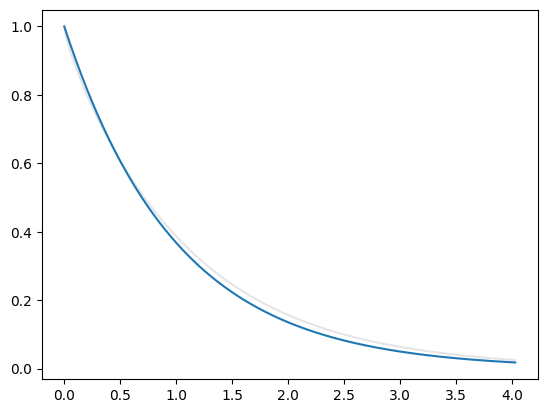

In [14]:
_, s_t = initialize_alpha_s(file_info["t_train"], file_info["delta_train"], n_cuts = 5)
tv = np.arange(0, s_t[-1], 0.01)
S1i = S1(tv, sim_results["new_alpha"], s_t)

plt.plot(tv, S1i, color = "black", alpha = 0.1)
plt.plot(tv, np.exp(-tv))


In [9]:
file_info = load_file("SimulationDataset2/Scenario{}/n{}/".format(1, 3000), 2, "logarithmic", train_images, test_images)

In [10]:
set_all_seeds(10)

sim_results = fit_cure_model("logarithmic", None,
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = 500,
               seed = 1, verbose = 3)

I0000 00:00:1741403057.576023   99154 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1741403058.614457   99284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741403058.617894   99284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741403060.938467   99284 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741403060.981561   99284 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4102 MB memory:  -> devi

Iniciando passo 1


I0000 00:00:1741403062.861780   99357 cuda_dnn.cc:529] Loaded cuDNN version 90300
 77%|███████▋  | 77/100 [00:31<00:09,  2.46epoch/s, loss=0.601, loss_val=0.6]  


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 8.791582891337926e-05
Distância Parâmetros Alpha: 285.475452680208
Média das distâncias: 142.73777029801843
Iniciando passo 2


 10%|█         | 10/100 [00:04<00:38,  2.34epoch/s, loss=0.726, loss_val=0.73]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.834615503559494e-07
Distância Parâmetros Alpha: 38.07521557371438
Média das distâncias: 19.037608078587965
Iniciando passo 3


  9%|▉         | 9/100 [00:04<00:41,  2.22epoch/s, loss=0.793, loss_val=0.801]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.3987871518380847e-07
Distância Parâmetros Alpha: 4.989370224330464
Média das distâncias: 2.4946852821045895
Iniciando passo 4


 11%|█         | 11/100 [00:05<00:41,  2.16epoch/s, loss=0.821, loss_val=0.831]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.302540708703961e-07
Distância Parâmetros Alpha: 0.8118580211024309
Média das distâncias: 0.40592932567825085
Iniciando passo 5


 10%|█         | 10/100 [00:04<00:43,  2.05epoch/s, loss=0.838, loss_val=0.847]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.6002222599099307e-07
Distância Parâmetros Alpha: 0.16115069473532778
Média das distâncias: 0.08057552737877689
Iniciando passo 6


  8%|▊         | 8/100 [00:03<00:42,  2.15epoch/s, loss=0.836, loss_val=0.848]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.8208420003835417e-07
Distância Parâmetros Alpha: 0.007467080146129742
Média das distâncias: 0.00373368111516489
Iniciando passo 7


 11%|█         | 11/100 [00:04<00:38,  2.32epoch/s, loss=0.847, loss_val=0.861]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.2991811197766026e-07
Distância Parâmetros Alpha: 0.03575713929770676
Média das distâncias: 0.01787878460790937
Iniciando passo 8


 12%|█▏        | 12/100 [00:05<00:40,  2.17epoch/s, loss=0.844, loss_val=0.86] 


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.257782818993648e-07
Distância Parâmetros Alpha: 0.0011710641872919826
Média das distâncias: 0.000585794982786941
Iniciando passo 9


 11%|█         | 11/100 [00:05<00:41,  2.15epoch/s, loss=0.844, loss_val=0.863]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.157631211402091e-07
Distância Parâmetros Alpha: 0.0035761889880737683
Média das distâncias: 0.0017883023755974543
Iniciando passo 10


 10%|█         | 10/100 [00:04<00:39,  2.28epoch/s, loss=0.842, loss_val=0.862]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.995342500668342e-07
Distância Parâmetros Alpha: 0.00016475362512467754
Média das distâncias: 8.252657968737219e-05
Learning rate reduzida para 0.0001
Iniciando passo 11


  7%|▋         | 7/100 [00:03<00:42,  2.20epoch/s, loss=0.847, loss_val=0.859]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.464697816709166e-09
Distância Parâmetros Alpha: 0.0005849852694875342
Média das distâncias: 0.0002924958670926754
Iniciando passo 12


  7%|▋         | 7/100 [00:03<00:43,  2.16epoch/s, loss=0.845, loss_val=0.856]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.711953861602822e-09
Distância Parâmetros Alpha: 0.00052369713002425
Média das distâncias: 0.0002618504209890558
Iniciando passo 13


  7%|▋         | 7/100 [00:03<00:42,  2.18epoch/s, loss=0.845, loss_val=0.856]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.750822063860988e-09
Distância Parâmetros Alpha: 4.269853067146992e-06
Média das distâncias: 2.1363019446054266e-06
Iniciando passo 14


  7%|▋         | 7/100 [00:03<00:43,  2.11epoch/s, loss=0.844, loss_val=0.856]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.1283926102494994e-09
Distância Parâmetros Alpha: 9.410740398356726e-07
Média das distâncias: 4.71601216222961e-07
Algoritmo convergiu após 14 iterações. Retornando.
Número de arquivos no diretório: 14


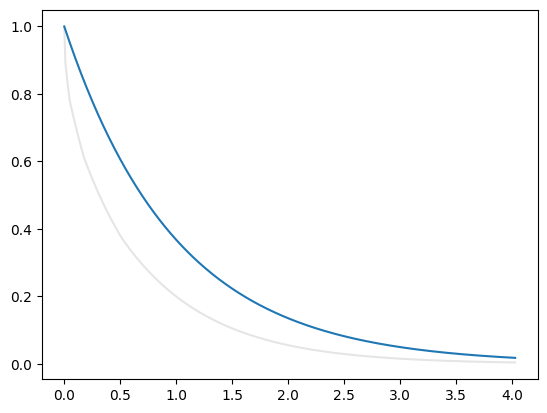

In [12]:
_, s_t = initialize_alpha_s(file_info["t_train"], file_info["delta_train"], n_cuts = 5)
tv = np.arange(0, s_t[-1], 0.01)
S1i = S1(tv, sim_results["new_alpha"], s_t)

plt.plot(tv, S1i, color = "black", alpha = 0.1)
plt.plot(tv, np.exp(-tv))

# Checking if simulations are running smoothly

In [6]:
def plot_S1(results, n, scenario, distribution, end_index = 101, ci = True, ax = None, title = "", outliers = 5):
    if(ax is None):
        fig, ax = plt.subplots(figsize = (12, 6))

    interest_indices = []
    for i in range(1, end_index):
        data = pd.read_csv("SimulationResults{}/Scenario{}/n{}/{}/{}/alpha_s.csv".format(results, scenario, n, distribution, i))
        s_t = data.s.to_numpy()
        alpha = data.alpha.to_numpy()
        if(i == 1):
            tv = np.arange(0, 5, 0.01)
            S1i = S1(tv, alpha, s_t)
    
            # Initialize the table with all estimated survival curves
            S1i_table = np.zeros((end_index-1, len(S1i)))
            S1i_table[0,:] = S1i
            
            alpha_xie = np.array([1, 1, 1, 1, 1, 1])
            S1v_xie = S1(tv, alpha_xie, s_t)
        else:
            S1i = S1(tv, alpha, s_t)
            S1i_table[i-1,:] = S1i

        ax.plot(tv, S1i, color = "black", alpha = 0.1)

            
    # Get the indices for which the simulation did not converge
    nan_indices = np.unique( np.where( np.isnan(S1i_table) )[0] )
    if(len(nan_indices) > 0):
        print("n = {} - {}: Simulações {} não obtiveram convergência!".format(n, distribution, nan_indices))
    # Remove the nan observations from the table
    S1i_table = np.delete(S1i_table, nan_indices, axis = 0)

    # Obtain the median survival curve
    S1_median = np.quantile(S1i_table, 0.50, axis = 0)
    
    # Takes the mean squared distances of all curves to the median
    median_distances = np.mean( (S1i_table - S1_median)**2, axis = 1 )
    # print(median_distances)
    
    # Sorts the distances vector to get the ranks of each curve (i.e. sorts the curves by distance from the median curve)
    index_sort_distances = np.argsort(np.argsort( median_distances ))
    
    # Remove from the table of curves the prespecified number of outlier curves (which are discarded for the predictions)
    S1i_table = S1i_table[ index_sort_distances < (end_index - 1 - outliers) , :]    
    
    S1q95 = np.quantile(S1i_table, 0.95, axis = 0)
    S1q05 = np.quantile(S1i_table, 0.05, axis = 0)
    S1_median = np.quantile(S1i_table, 0.50, axis = 0)
    
    ax.plot(tv, S1v_xie, color = "blue", linewidth = 2)
    # ax.plot(tv, np.exp(-tv), color = "black", linewidth = 2)
    
    if(ci):
        ax.plot(tv, S1q95, color = "red", linestyle = "dashed")
        ax.plot(tv, S1q05, color = "red", linestyle = "dashed")
        ax.plot(tv, S1_median, color = "red", linewidth = 2)

    ax.set_title(title)

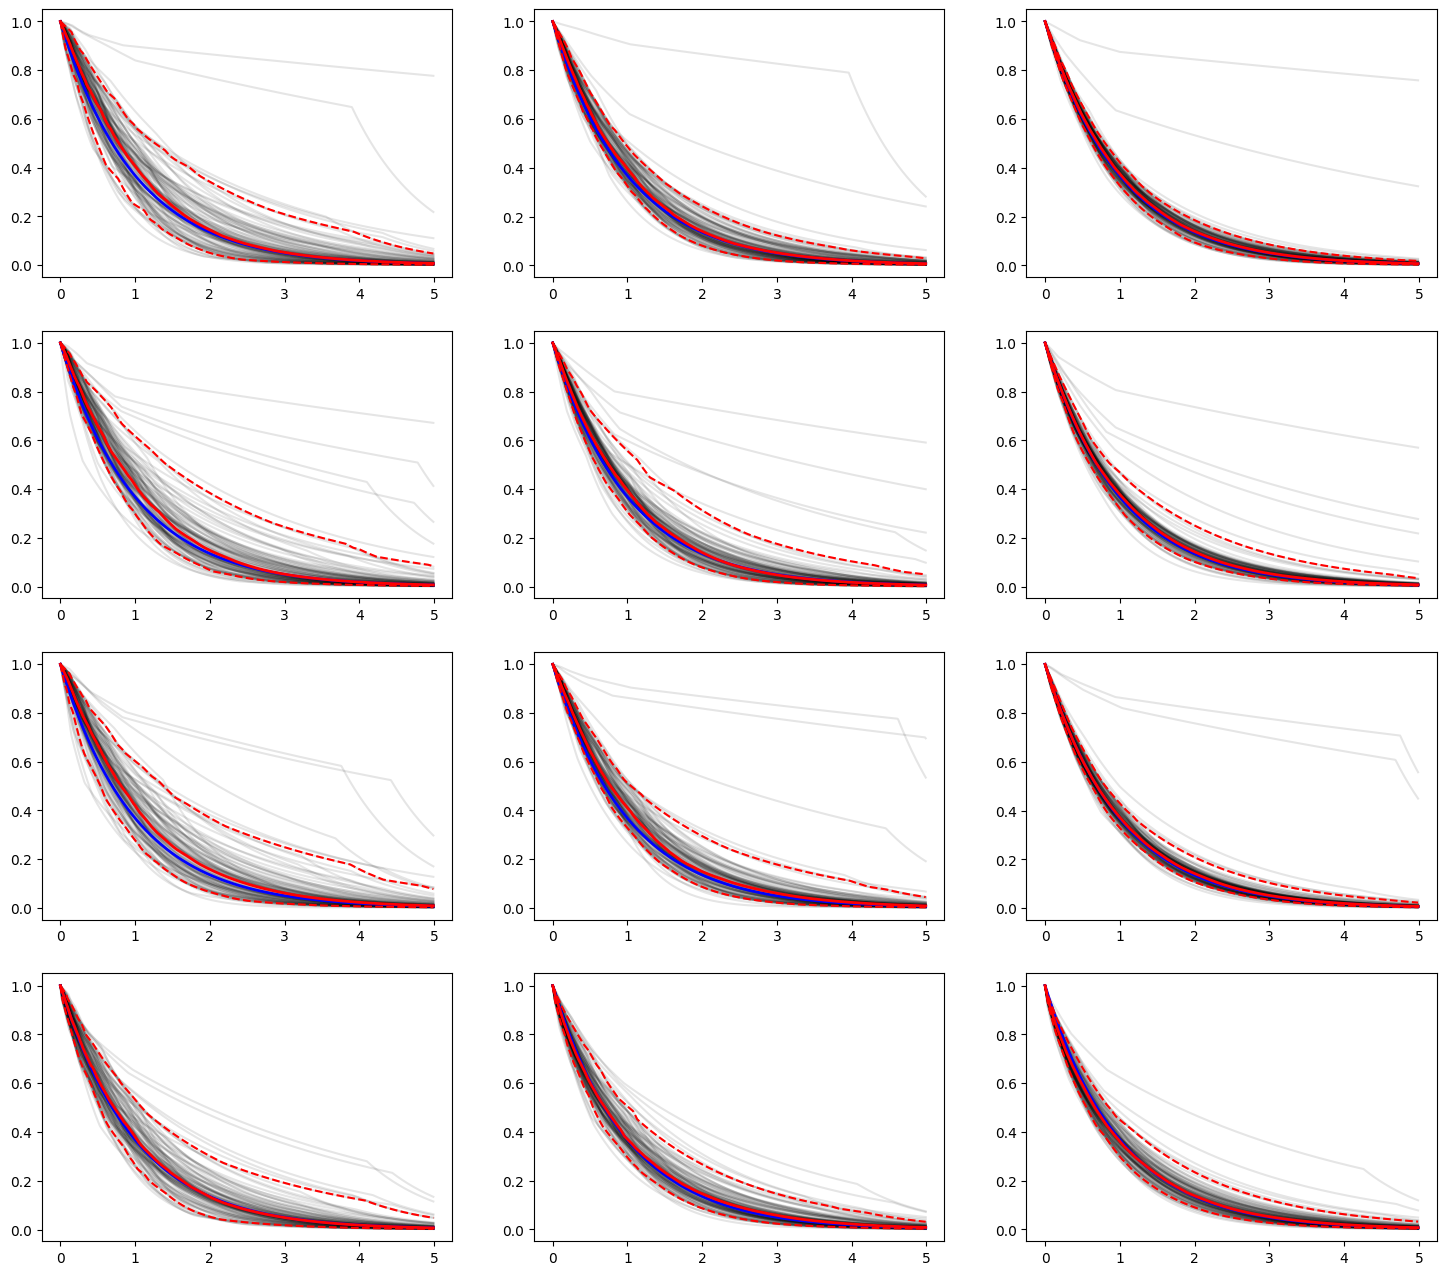

In [6]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (18,16))

ci = True
outliers = 0
plot_S1("2", 500, 2, "borel", 101, ci = ci, ax = ax[0,0], outliers = outliers)
plot_S1("2", 1000, 2, "borel", 101, ci = ci, ax = ax[0,1], outliers = outliers)
plot_S1("2", 3000, 2, "borel", 101, ci = ci, ax = ax[0,2], outliers = outliers)

plot_S1("2", 500, 2, "haight", 101, ci = ci, ax = ax[1,0], outliers = outliers)
plot_S1("2", 1000, 2, "haight", 101, ci = ci, ax = ax[1,1], outliers = outliers)
plot_S1("2", 3000, 2, "haight", 101, ci = ci, ax = ax[1,2], outliers = outliers)

plot_S1("2", 500, 2, "geeta3", 101, ci = ci, ax = ax[2,0], outliers = outliers)
plot_S1("2", 1000, 2, "geeta3", 101, ci = ci, ax = ax[2,1], outliers = outliers)
plot_S1("2", 3000, 2, "geeta3", 101, ci = ci, ax = ax[2,2], outliers = outliers)

plot_S1("2", 500, 2, "rgp2", 101, ci = ci, ax = ax[3,0], outliers = outliers)
plot_S1("2", 1000, 2, "rgp2", 101, ci = ci, ax = ax[3,1], outliers = outliers)
plot_S1("2", 3000, 2, "rgp2", 101, ci = ci, ax = ax[3,2], outliers = outliers)

# Alpha estimation for Scenario 1

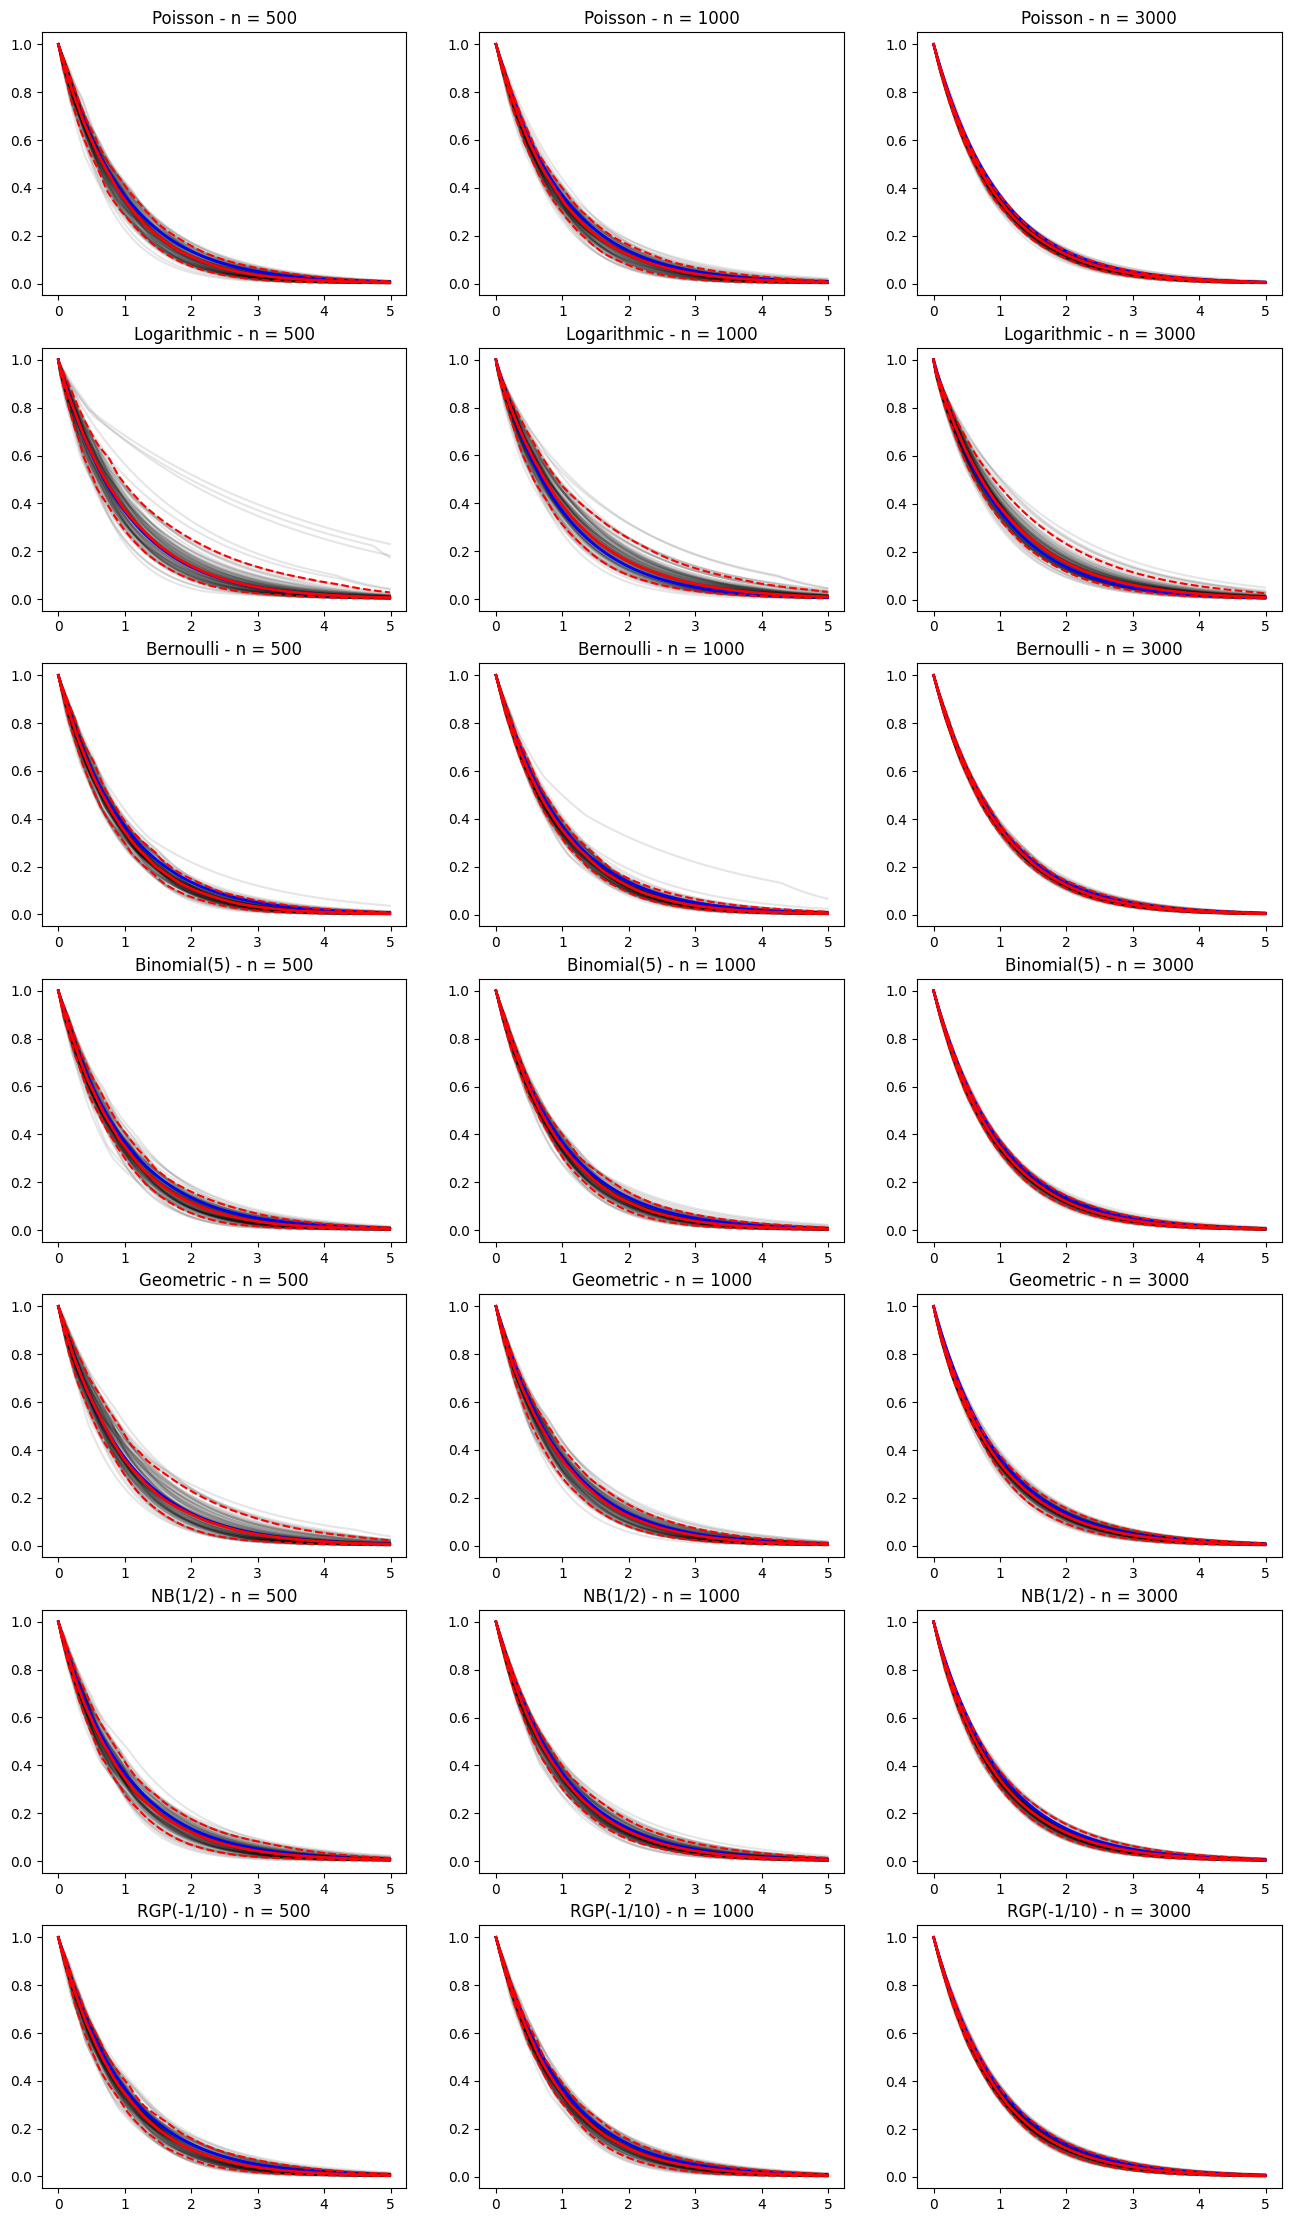

In [7]:
fig, ax = plt.subplots(nrows = 7, ncols = 3, figsize = (16,28))

ci = True
outliers = 0
plot_S1("2", 500, 1, "poisson", 101, ax = ax[0,0], title = "Poisson - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "poisson", 101, ax = ax[0,1], title = "Poisson - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "poisson", 101, ax = ax[0,2], title = "Poisson - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "logarithmic", 101, ax = ax[1,0], title = "Logarithmic - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "logarithmic", 101, ax = ax[1,1], title = "Logarithmic - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "logarithmic", 101, ax = ax[1,2], title = "Logarithmic - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "bernoulli", 101, ax = ax[2,0], title = "Bernoulli - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "bernoulli", 101, ax = ax[2,1], title = "Bernoulli - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "bernoulli", 101, ax = ax[2,2], title = "Bernoulli - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "bin5", 101, ax = ax[3,0], title = "Binomial(5) - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "bin5", 101, ax = ax[3,1], title = "Binomial(5) - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "bin5", 101, ax = ax[3,2], title = "Binomial(5) - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "geometric", 101, ax = ax[4,0], title = "Geometric - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "geometric", 101, ax = ax[4,1], title = "Geometric - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "geometric", 101, ax = ax[4,2], title = "Geometric - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "mvnb2", 101, ax = ax[5,0], title = "NB(1/2) - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "mvnb2", 101, ax = ax[5,1], title = "NB(1/2) - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "mvnb2", 101, ax = ax[5,2], title = "NB(1/2) - n = 3000", ci = ci, outliers = outliers)

plot_S1("2", 500, 1, "rgp10", 101, ax = ax[6,0], title = "RGP(-1/10) - n = 500", ci = ci, outliers = outliers)
plot_S1("2", 1000, 1, "rgp10", 101, ax = ax[6,1], title = "RGP(-1/10) - n = 1000", ci = ci, outliers = outliers)
plot_S1("2", 3000, 1, "rgp10", 101, ax = ax[6,2], title = "RGP(-1/10) - n = 3000", ci = ci, outliers = outliers)

# Alpha estimation for Scenario 2

To build the plot below, you have to comment the line "x = tf.cast(x, dtype = tf.float64)" on "custom_model.py" inside the method "call()". We are not keeping that line commented for the running code, given it may be unecessarily difficult to work around that in this case, other than just comment and uncomment a line of code.

In [16]:
dummy_mps_model.summary()

Model: "mp_scr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,720 (2.39 MB)

 Trainable params: 627,720 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

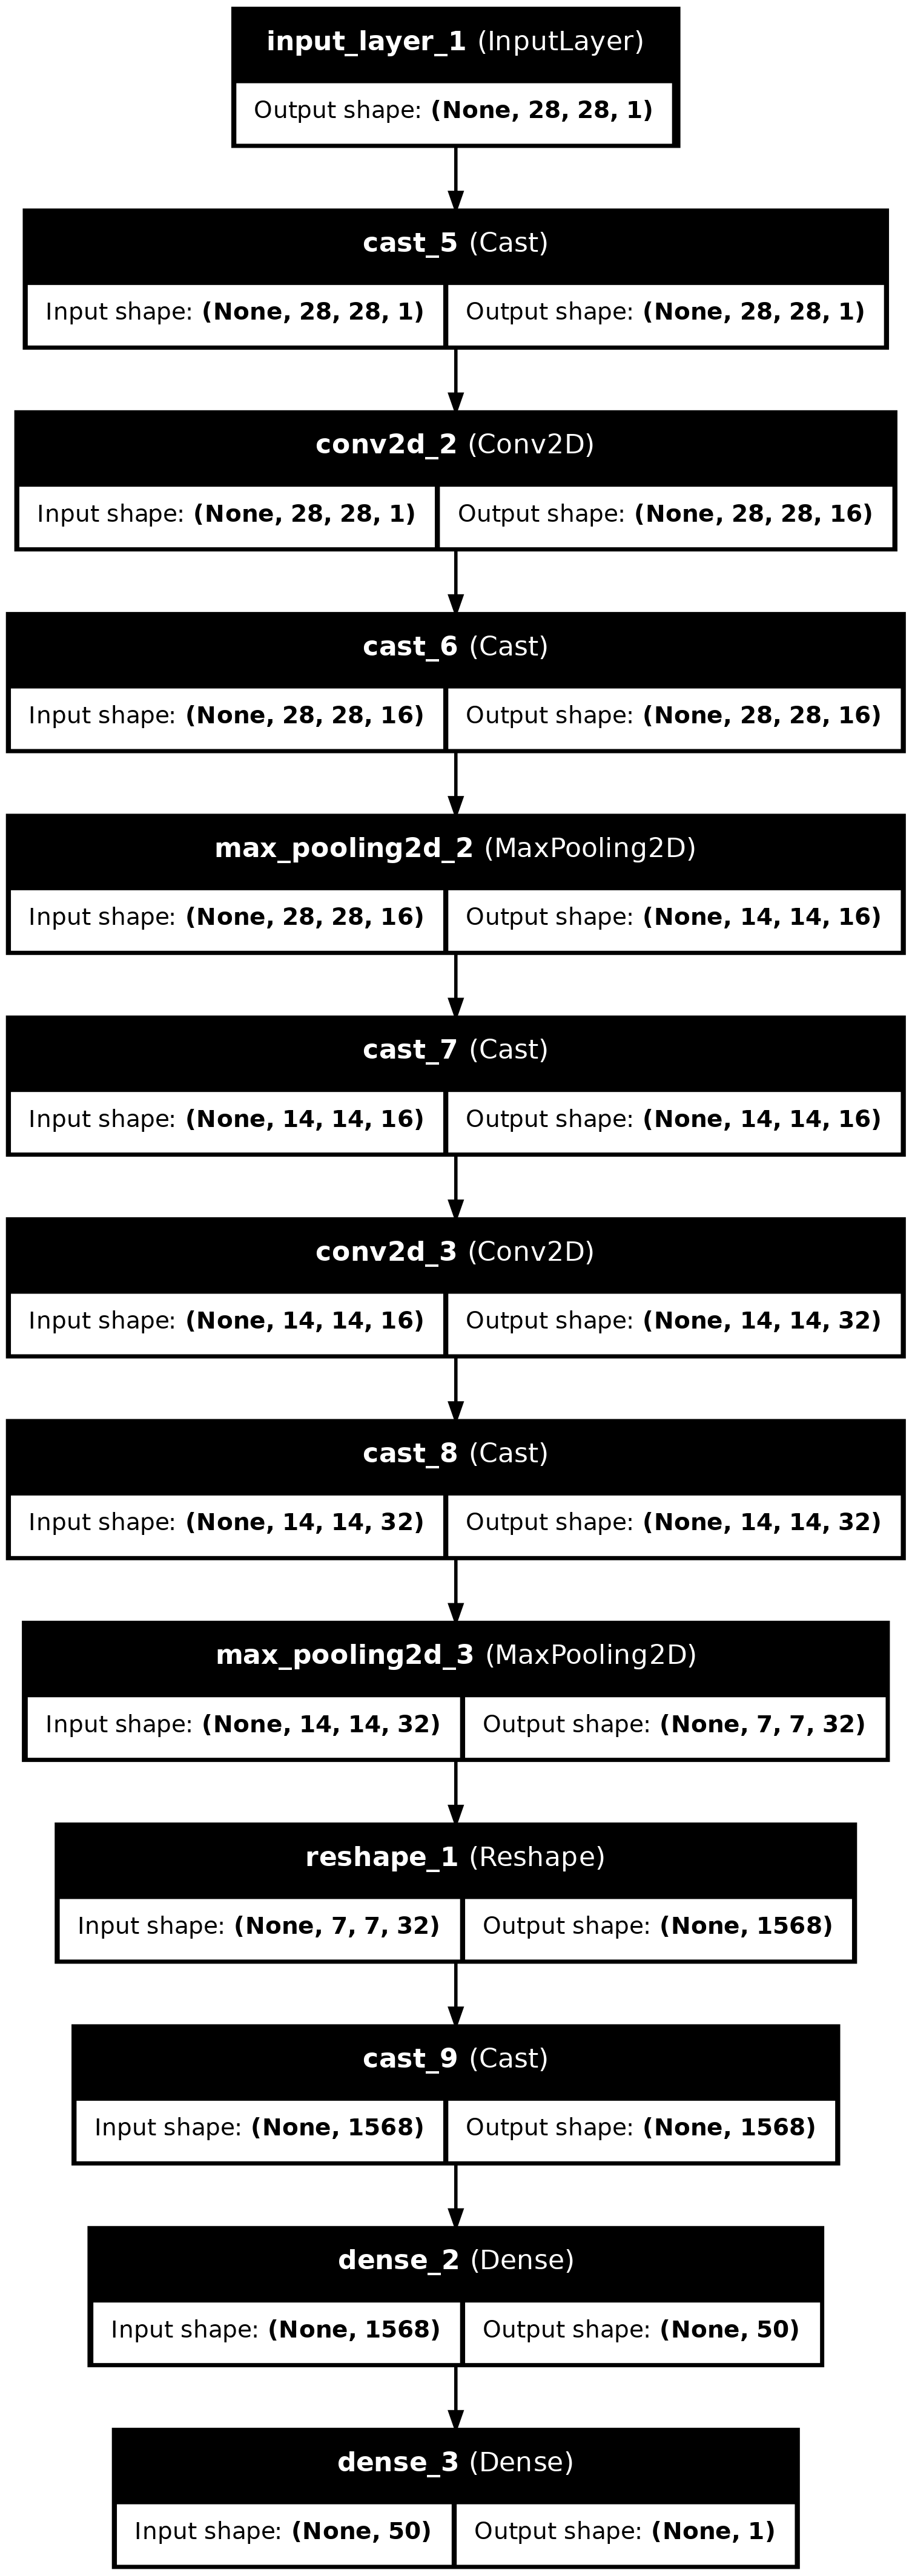

In [5]:
from keras.utils import plot_model

dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
dummy_mps_model.define_structure(shape_input = train_images[0].shape, seed = 1)
plot_model(dummy_mps_model.build_graph(), show_shapes=True, show_layer_names=True)

In [6]:
dummy_mps_model.summary()

Model: "mp_scr_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        78,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,300 (325.39 KB)

 Trainable params: 83,300 (325.39 KB)

 Non-trainable params: 0 (0.00 B)